# Notebook for RL agent in trading

In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import quandl
import torch
yf.pdr_override() 

## Yahoo API

In [2]:
# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'SPY'

### Define the pêriod

In [3]:
# Define the time period for historical data
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 1, 1)

### Get data from web

In [4]:
# data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)
# data.head()

### Save to CSV

In [5]:
# data.to_csv('SPY.csv')

### Get downloaded data

In [6]:
data = pd.read_csv('SPY.csv')
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_average
0,2015-01-02,206.380005,206.880005,204.179993,205.429993,174.806732,121465900,NaN
1,2015-01-05,204.169998,204.369995,201.350006,201.720001,171.649857,169632600,NaN
2,2015-01-06,202.089996,202.720001,198.860001,199.820007,170.033112,209151400,NaN
3,2015-01-07,201.419998,202.720001,200.880005,202.309998,172.151855,125346700,NaN
4,2015-01-08,204.009995,206.160004,203.990005,205.899994,175.206696,147217800,NaN


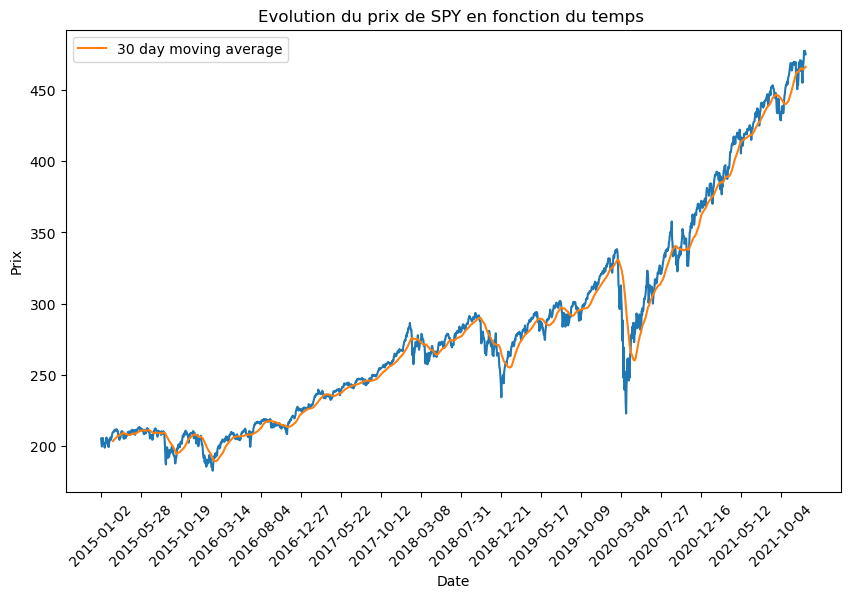

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data["Date"].to_numpy(), data['Close'].to_numpy(), linestyle='-')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')

plt.xlabel("Date")
plt.ylabel("Prix")

# do not plot all xticks
plt.xticks(data["Date"][::100], rotation=45)
plt.legend()
plt.title(f"Evolution du prix de {stock_symbol} en fonction du temps ")
plt.show()


## Implement DQNetwork

### Parameters

In [8]:
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN, DQN_with_Transformer
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

# Parameters
T = 20 
price_list_size = 1
sync_period=30
lr = 0.01 # 0.001
rb = 2000 # 2000
es = 0.82 # 0.82
em = 0.013 # 0.013
ed = 0.9675 # 0.9675
num_episodes=300 # 100
gamma=0.9 # 0.9
batch_size=128 # 128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device


'cuda'

In [9]:
# initializing a model and a target model
print("Creating Models ...")
model = DQN_with_Transformer(price_list_size, T+1, 1, 1, device).to(device)
target_model = DQN_with_Transformer(price_list_size, T+1, 1, 1, device).to(device)
print("... Models Created\n")

# initializing the optimizer, lr_scheduler and loss function
print("Creating Optimizer, LR Scheduler and Loss Function ...")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
            # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()
print("... Optimizer, LR Scheduler and Loss Function Created\n")

# initializing the replay buffer
print("Creating Replay Buffer ...")
replay_buffer = ReplayBuffer(rb)                                                                                                                    
print("... Replay Buffer Created\n")

# initializing the environment
print("Creating Environment ...")
env = SimplifiedStockTradingEnv(data, T=T)
print("... Environment Created\n")

# initializing the epsilon greedy strategy
print("Creating Epsilon Greedy Strategy ...")
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("... Epsilon Greedy Strategy Created\n")

# initializing the agent
print("Creating Agent ...")
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created\n")

Creating Models ...


/users/eleves-b/2021/mathias.grau/.local/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


... Models Created

Creating Optimizer, LR Scheduler and Loss Function ...
... Optimizer, LR Scheduler and Loss Function Created

Creating Replay Buffer ...
... Replay Buffer Created

Creating Environment ...
... Environment Created

Creating Epsilon Greedy Strategy ...
... Epsilon Greedy Strategy Created

Creating Agent ...
... agent Created



### Training Agent

In [10]:
episode_reward_list = agent.train(num_episodes, gamma, batch_size)

  0%|          | 0/300 [00:00<?, ?it/s]

Episode 1, reward: 516.31, percentage of random = 0.83
Episode 2, reward: 650.54, percentage of random = 0.79
Episode 3, reward: 592.17, percentage of random = 0.78
Episode 4, reward: 603.96, percentage of random = 0.75
Episode 5, reward: 654.73, percentage of random = 0.72
Episode 6, reward: 488.12, percentage of random = 0.70
Episode 7, reward: 591.68, percentage of random = 0.66
Episode 8, reward: 485.33, percentage of random = 0.65
Episode 9, reward: 416.75, percentage of random = 0.63
Episode 10, reward: 555.04, percentage of random = 0.60
Episode 11, reward: 525.18, percentage of random = 0.58
Episode 12, reward: 607.81, percentage of random = 0.55


## Global results

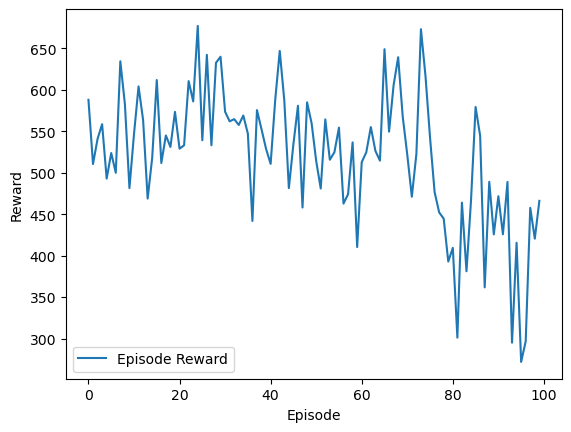

In [ ]:
plt.plot(episode_reward_list, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.savefig("episode_reward.png")
plt.show()

## Results for the first episode

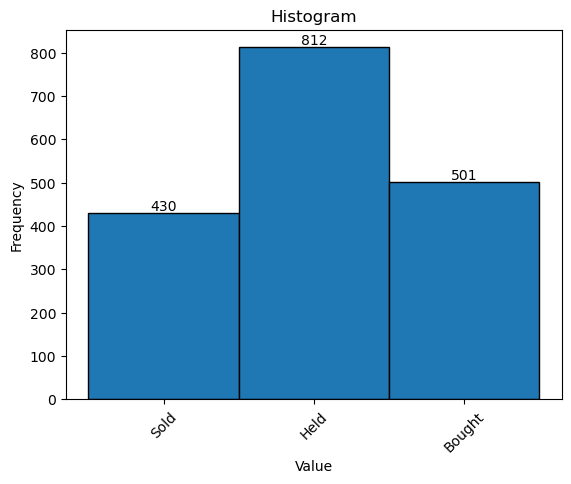

In [ ]:
import numpy as np

num_bins = 3
bin_edges = np.linspace(min(agent.action_list[0]), max(agent.action_list[0]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[0], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()

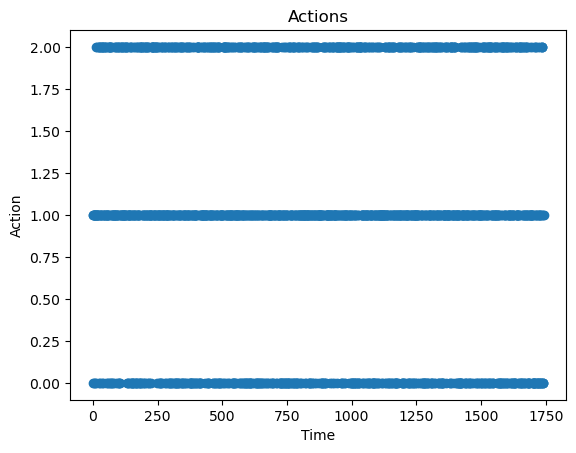

In [ ]:

plt.scatter(range(len(agent.action_list[0])), agent.action_list[0])
plt.title('Actions')
plt.xlabel('Time')
plt.ylabel('Action')
plt.show()


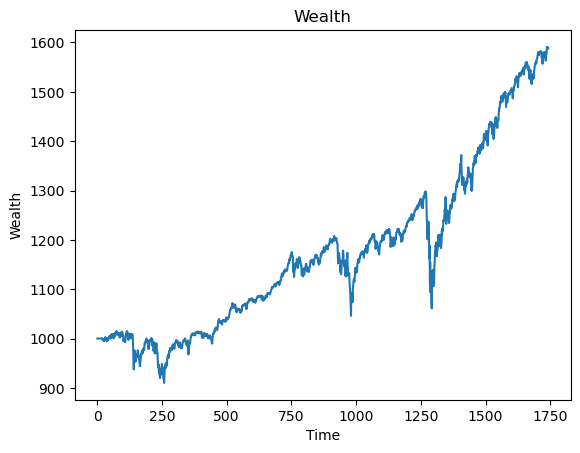

In [ ]:

plt.plot(agent.wealth_list[0])
plt.title('Wealth')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()


## Results for the last episode

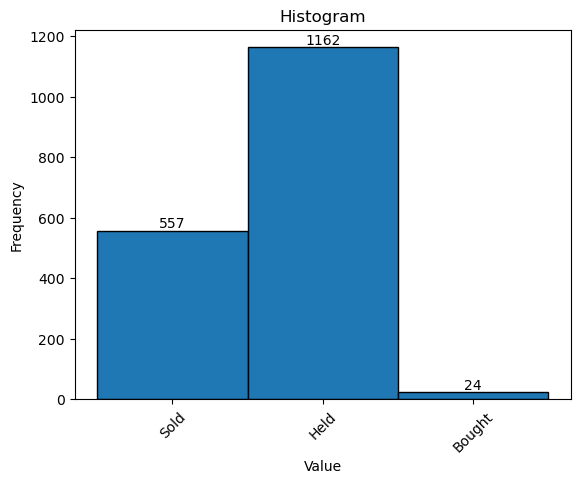

In [ ]:

bin_edges = np.linspace(min(agent.action_list[-1]), max(agent.action_list[-1]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[-1], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()


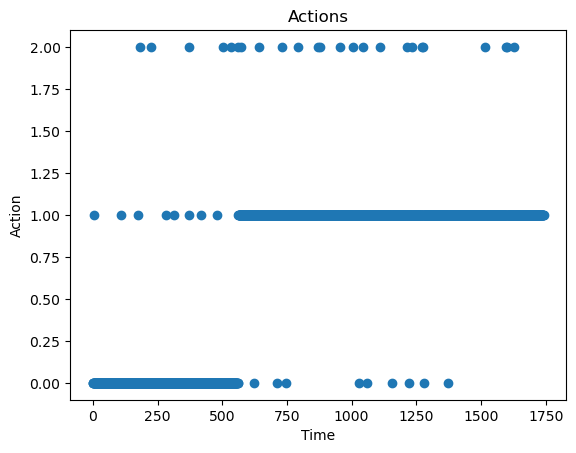

In [ ]:
plt.scatter(range(len(agent.action_list[-1])), agent.action_list[-1])
plt.title('Actions')
plt.xlabel('Time')
plt.ylabel('Action')
plt.show()


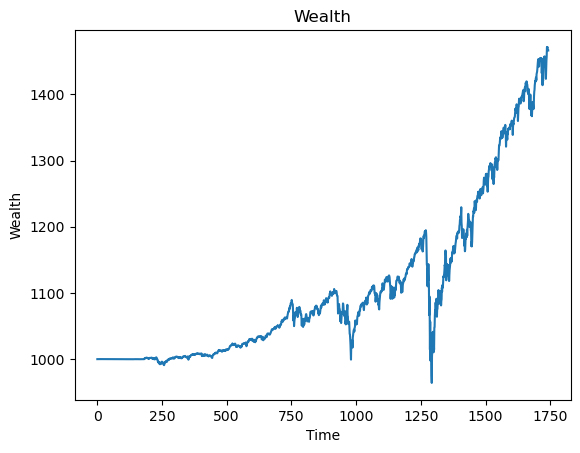

In [ ]:
plt.plot(agent.wealth_list[-1])
plt.title('Wealth')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

In [ ]:
import os
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from email.utils import formataddr
import time

# Informations de connexion au serveur Zimbra
smtp_server = 'webmail.polytechnique.fr'
smtp_port = 587  # Utilisez le port SMTP approprié pour Zimbra
smtp_username = 'prenom.nom'
smtp_password = 'mot_de_passe'



# Sender and recipient details
from_email = 'resultat_simulation_rl@polytechnique.edu'
to_email = ['prenom.nom@polytechnique.edu']
subject = 'Résultat simulation RL'

# Corps du message
message_text = "Voici le résultat de la simulation RL"
# Signature HTML
signature_html = "<p>Cordialement,<br>Prénom Nom</p>"
# Create the MIMEMultipart object
msg = MIMEMultipart()
msg['From'] = formataddr((None, from_email))  # Ensure proper encoding for sender
msg['To'] = ', '.join(to_email)
msg['Subject'] = subject

# Attach the image
attachment_path = 'episode_reward.png'
with open(attachment_path, 'rb') as file:
    attachment = MIMEApplication(file.read(), name=os.path.basename(attachment_path))
    msg.attach(attachment)

# Add the message body
message = MIMEText(f"{message_text}<br><br>{signature_html}", 'html', _charset='utf-8')  # Ensure UTF-8 encoding

msg.attach(message)



# Initialize SMTP connection
server = smtplib.SMTP(smtp_server, smtp_port)
server.starttls()
server.login(smtp_username, smtp_password)

# Send the email
server.sendmail(from_email, to_email, msg.as_string())

# Close the SMTP connection
server.quit()

print(f"L'e-mail a été envoyé avec succès à {to_email}, le {time.strftime('%d/%m/%Y à %H:%M:%S')}")


L'e-mail a été envoyé avec succès à ['mathias.grau@polytechnique.edu'], le 20/03/2024 à 22:06:34
